## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Dataset

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# Install Dataset
!pip install kaggle --quiet
!kaggle datasets download -d rakannimer/air-passengers
!unzip -q /content/air-passengers.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/rakannimer/air-passengers
License(s): DbCL-1.0
  0% 0.00/764 [00:00<?, ?B/s]
100% 764/764 [00:00<00:00, 1.13MB/s]


## Explanatory Data Analysis (EDA)

In [ ]:
data = pd.read_csv('/content/AirPassengers.csv')

In [ ]:
data = data.rename(columns={'#Passengers': 'Passengers'})

In [ ]:
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

In [ ]:
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [ ]:
data.isnull().sum()

,0
Passengers,0


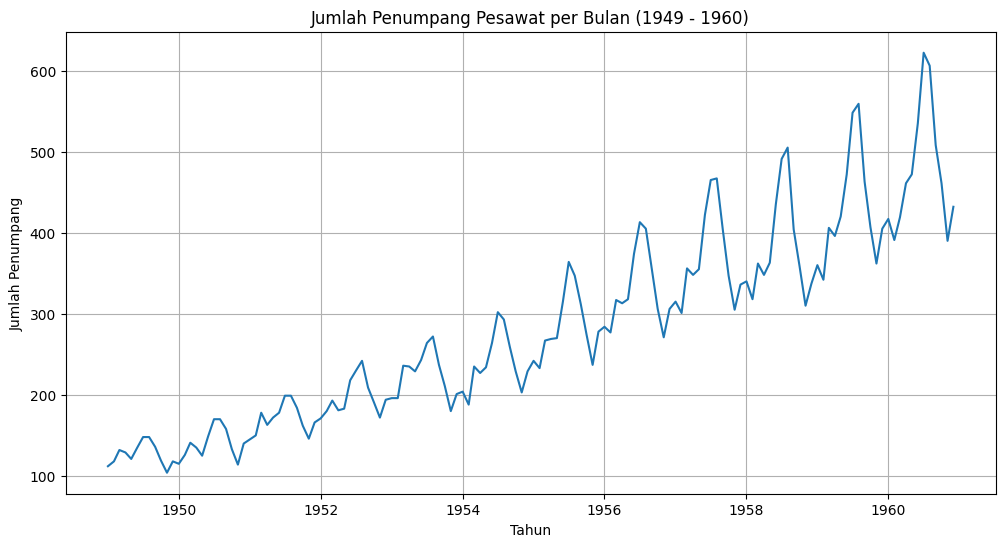

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data, linestyle='-')
plt.title("Jumlah Penumpang Pesawat per Bulan (1949 - 1960)")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Penumpang")
plt.grid()
plt.show()

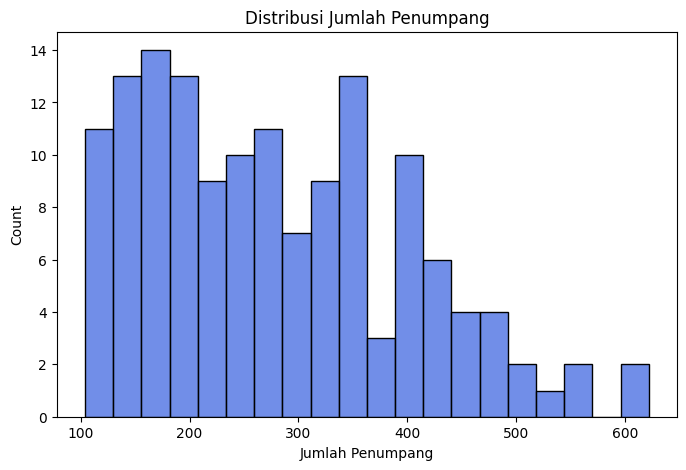

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Passengers'], bins=20, color='royalblue')
plt.title("Distribusi Jumlah Penumpang")
plt.xlabel("Jumlah Penumpang")
plt.show()

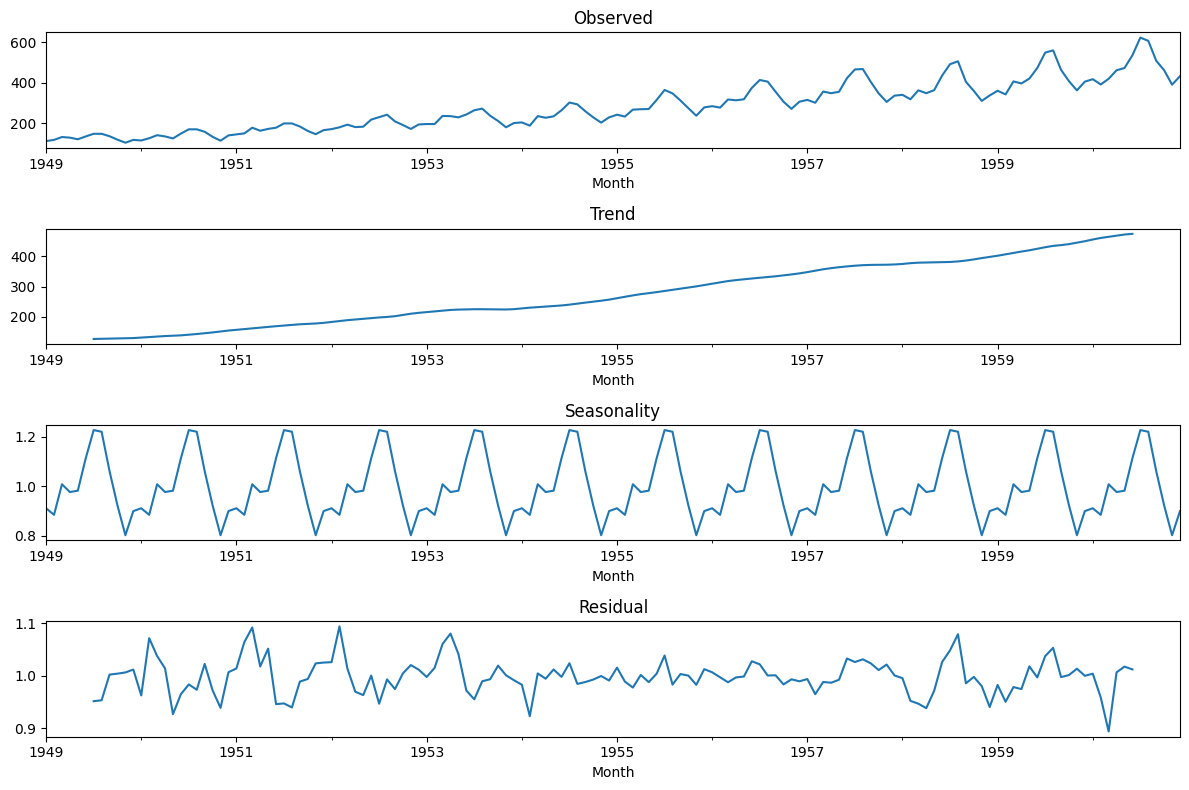

In [ ]:
decomposition = seasonal_decompose(data, model='multiplicative', period=12)
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residual")
plt.tight_layout()
plt.show()

### Preprocessing Data

In [ ]:
train = data[:'1959']
test = data['1960':]

## Modeling

In [ ]:
model = SARIMAX(train['Passengers'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_model = model.fit(disp=False)

## Modeling Result

In [ ]:
print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -396.681
Date:                            Sun, 02 Feb 2025   AIC                            803.363
Time:                                    06:52:16   BIC                            816.633
Sample:                                01-01-1949   HQIC                           808.740
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5400      0.338     -1.596      0.110      -1.203       0.123
ma.L1          0.3075      0.368   

## Prediction

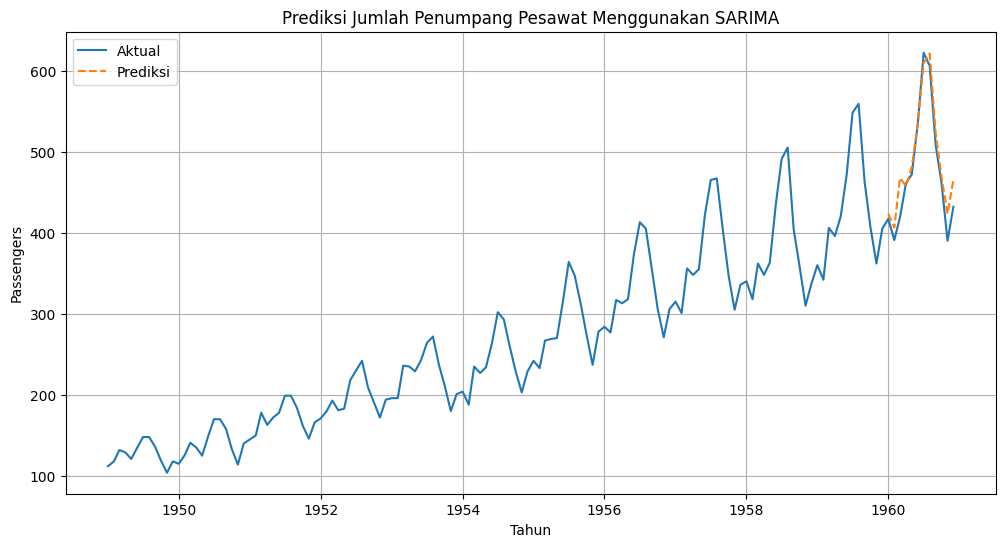

In [ ]:
data['Predicted'] = sarima_model.predict(start=len(data)-12, end=len(data)+11, dynamic=False)

plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'], label="Aktual")
plt.plot(data['Predicted'], label="Prediksi", linestyle='dashed')
plt.title("Prediksi Jumlah Penumpang Pesawat Menggunakan SARIMA")
plt.xlabel("Tahun")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

In [ ]:
actual = data['Passengers']['1960':].dropna()
predicted = data['Predicted'].dropna()

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"\nEvaluasi Model SARIMA:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Evaluasi Model SARIMA:
Mean Absolute Error (MAE): 16.67
Root Mean Squared Error (RMSE): 21.62


In [ ]:
data['Difference'] = data['Passengers'] - data['Predicted']

print(data[['Passengers', 'Predicted', 'Difference']].dropna().tail(12))


            Passengers   Predicted  Difference
Month                                         
1960-01-01         417  423.220776   -6.220776
1960-02-01         391  406.433567  -15.433567
1960-03-01         419  467.547433  -48.547433
1960-04-01         461  457.478940    3.521060
1960-05-01         472  480.937601   -8.937601
1960-06-01         535  534.599304    0.400696
1960-07-01         622  609.414970   12.585030
1960-08-01         606  621.009678  -15.009678
1960-09-01         508  523.363515  -15.363515
1960-10-01         461  468.643695   -7.643695
1960-11-01         390  423.339480  -33.339480
1960-12-01         432  465.073605  -33.073605


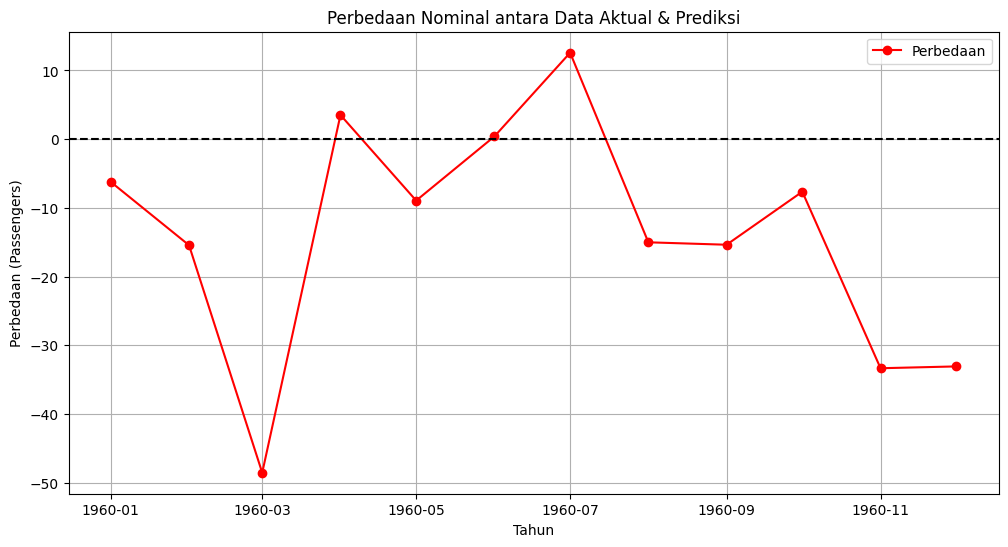

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(data.index, data['Difference'], label="Perbedaan", color='red', linestyle='-', marker='o')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Perbedaan Nominal antara Data Aktual & Prediksi")
plt.xlabel("Tahun")
plt.ylabel("Perbedaan (Passengers)")
plt.legend()
plt.grid()

plt.show()
